In [ ]:
# lstm autoencoder predict sequence
import numpy as np
import pandas as pd
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed
from keras.utils import plot_model
import matplotlib.pyplot as plt
# Reference: https://scikit-learn.org/stable/modules/clustering.html#clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import datasets, metrics
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


G Drive connect for data

In [ ]:
gdrive_project_pathname = '/My Drive/w210'  #@param {type: "string"}

In [ ]:
import os.path
from google.colab import drive

# Mount the current user's Google Drive
GOOGLE_DRIVE_MOUNT_POINT = "/content/drive"
print("Mounting Google Drive beneath %s" % GOOGLE_DRIVE_MOUNT_POINT)
drive.mount(GOOGLE_DRIVE_MOUNT_POINT, force_remount = True)

# Build the pathname to the project's folder residing beneath the current user's Google Drive
if not gdrive_project_pathname.startswith("/"):
  gdrive_project_pathname = "/" + gdrive_project_pathname
abs_project_pathname = GOOGLE_DRIVE_MOUNT_POINT + gdrive_project_pathname
print("Project folder: %s" % gdrive_project_pathname)


Mounting Google Drive beneath /content/drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Project folder: /My Drive/w210


Define a function to convert Pandas DataFrame outputted from `satellite_imagery(..., plot_option='no')` to numpy array

In [ ]:
def time_series_prep(in_df, stat_option):
    col_lst = list(in_df.columns)
    col_lst_select = [i for i in col_lst if stat_option in i]
    # Rearrange the order the columns based on YYYYMM
    col_lst_select.sort()
    out_df = in_df[col_lst_select]
    return out_df.to_numpy()

Define a function to perform K-means classification

In [ ]:
def kmeans(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    km = KMeans(n_clusters=n_classes)
    km.fit(in_arr)
    km.predict(in_arr)
    labels = km.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform Agglomerative Clustering

In [ ]:
def agglomerative(in_arr, n_classes):
    # Reference: https://towardsdatascience.com/clustering-based-unsupervised-learning-8d705298ae51
    aggClus = AgglomerativeClustering(n_clusters=n_classes).fit(in_arr)
    labels = aggClus.labels_
    # Reference: https://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient
    print('Silhouette Coefficient is: ', metrics.silhouette_score(in_arr, labels, metric='euclidean'))
    #Plotting
    if in_arr.shape[1] > 2:
        fig = plt.figure(1, figsize=(7,7))
        ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
        ax.scatter(in_arr[:, 0], in_arr[:, 1], in_arr[:, 2],
                  c=labels.astype(np.float), edgecolor="k", s=50)
        ax.set_xlabel("feature_1")
        ax.set_ylabel("feature_2")
        ax.set_zlabel("feature_3")
        plt.title("K Means", fontsize=14)
    elif in_arr.shape[1] == 2:
        in_df = pd.DataFrame(in_arr, columns=["feature_1", "feature_2"])
        pred_series = pd.Series(labels, name="Class")
        plot_df = in_df.merge(pred_series.to_frame(), left_index=True, right_index=True)
        sns.scatterplot(data=plot_df, x='feature_1', y='feature_2', hue='Class')
    return labels

Define a function to perform LSTM encode and decode actions

In [ ]:
def LSTM_autoencoder(in_arr, n_features, n_epochs):
    # Reference: https://machinelearningmastery.com/lstm-autoencoders/
    # reshape input into [samples, timesteps, features] if needed
    sequence = in_arr.reshape((in_arr.shape[0], in_arr.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(n_features, activation='relu', input_shape=(in_arr.shape[1],1)))
    model.add(RepeatVector(in_arr.shape[1]))
    model.add(LSTM(n_features, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    # fit model
    history = model.fit(sequence, sequence, validation_split = 0.5, epochs=n_epochs)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    # plt.title('model accuracy')
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()
    
    # connect the encoder LSTM as the output layer
    model = Model(inputs=model.inputs, outputs=model.layers[0].output)
    # get the feature vector for the input sequence
    yhat = model.predict(sequence)
    return yhat

In [ ]:
def LSTM_autoencoder_plus(in_arr, n_features, n_epochs):
    check = 0
    while (check == 0):
        yhat = LSTM_autoencoder(in_arr, n_features, n_epochs)
        nrows = in_arr.shape[0]
        check = 1
        for col in range(n_features):
            n_zeros = (yhat[:,col]==0).sum()
            print('Column {} has {:.2%} of zeros'.format(col, n_zeros/nrows))
            if n_zeros == nrows:
                check = 0
        if check == 0:
            print('At least 1 column is all zeros. Refit -------------------------------------------')
    return yhat

Read in data output from `GEE_SatelliteImagery_EDA.ipynb`

In [ ]:
ID_df = pd.read_csv(abs_project_pathname + '/data/time_series_ID_scale10_SENTINEL2_1C_06202020.csv')
ID_df.head()

,Unnamed: 0,lat,lon,201801_NDVI,201801_SAVI,201801_EVI,201802_NDVI,201802_SAVI,201802_EVI,201803_NDVI,201803_SAVI,201803_EVI
0,0,25.735251,84.042291,0.297372,0.569980,-1.276205,0.544098,0.292124,-1.995029,0.331038,0.496475,-3.043406
1,1,25.735251,84.042291,0.297372,0.569980,-1.276205,0.505260,0.853558,-0.994563,0.331038,0.496475,-3.043406
2,2,25.735251,84.042560,0.406650,0.576845,-1.292759,0.585787,0.302869,-2.254829,0.242168,0.363195,-2.483174
3,3,25.735251,84.042560,0.406650,0.576845,-1.292759,0.523024,0.942164,-0.896508,0.242168,0.363195,-2.483174
4,4,25.735251,84.042830,0.372183,0.688175,-1.600326,0.567393,0.274536,-1.634289,0.169206,0.253770,-0.430132


In [ ]:
ID_arr = time_series_prep(in_df=ID_df, stat_option='SAVI')

Model 1: K-Means

Silhouette Coefficient is:  0.3557770607808272


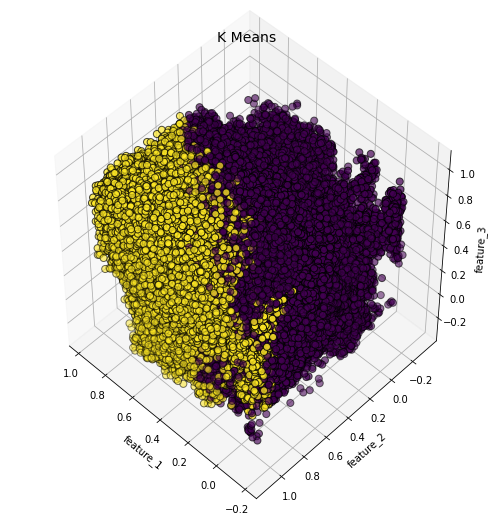

In [ ]:
ID_label = kmeans(in_arr=ID_arr, n_classes=2)

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


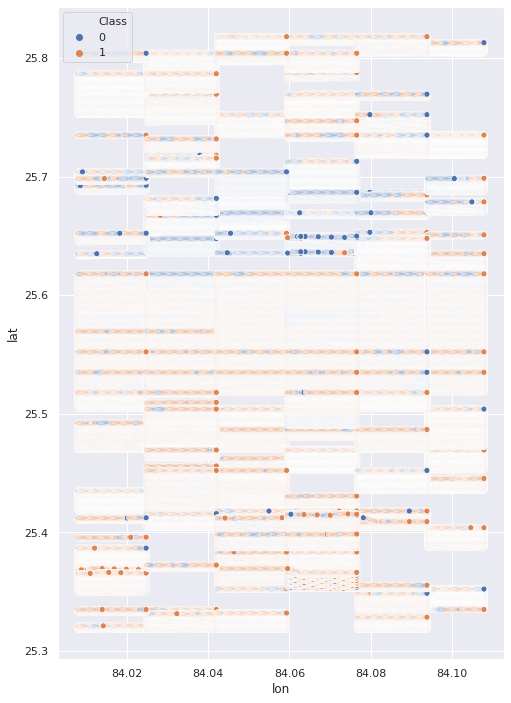

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 2: Agglomerative Clustering

In [ ]:
ID_label = agglomerative(in_arr=ID_arr, n_classes=2)

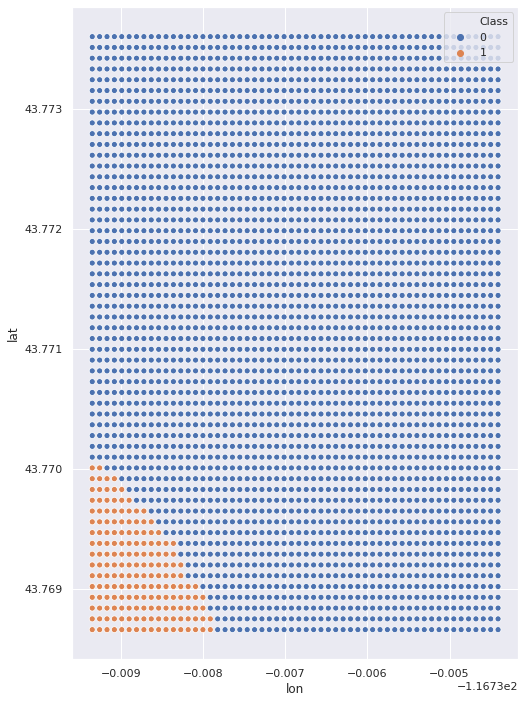

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Model 3: LSTM Autoencoder + K-Means

In [ ]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

NameError: ignored

Silhouette Coefficient is:  0.46265715


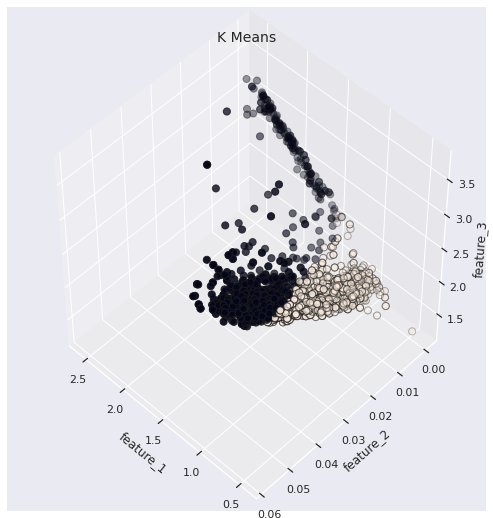

In [ ]:
ID_label = kmeans(in_arr=ID_feature, n_classes=2)

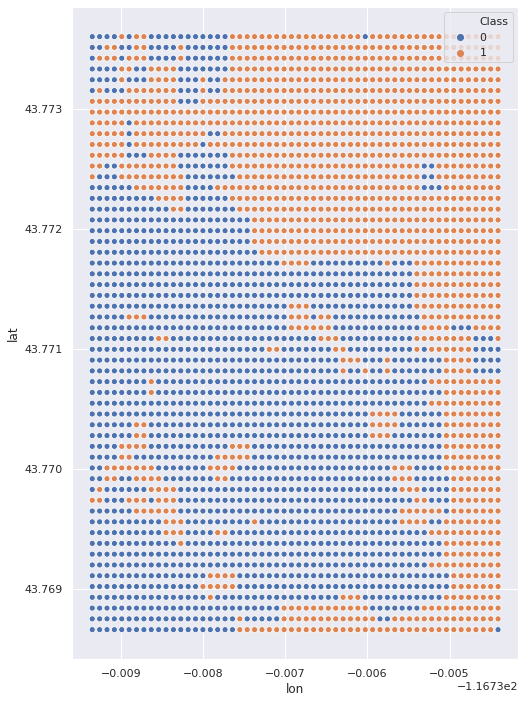

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

===========================================================================================================

In [ ]:
ID_df = pd.read_csv(abs_project_pathname + '/time_series_India_scale10.csv')
ID_arr = time_series_prep(in_df=ID_df, stat_option='SAVI')

Silhouette Coefficient is:  0.3240289627880457


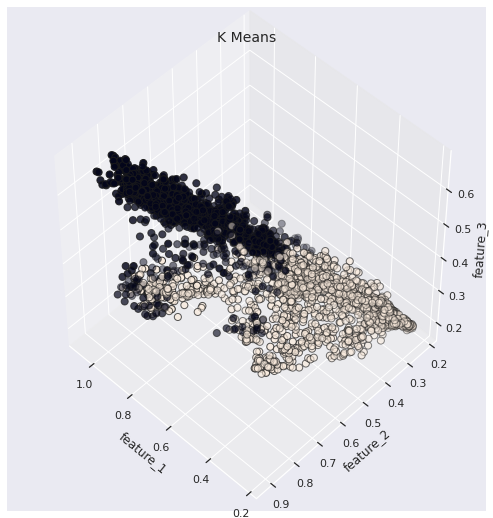

In [ ]:
ID_label = kmeans(in_arr=ID_arr, n_classes=2)

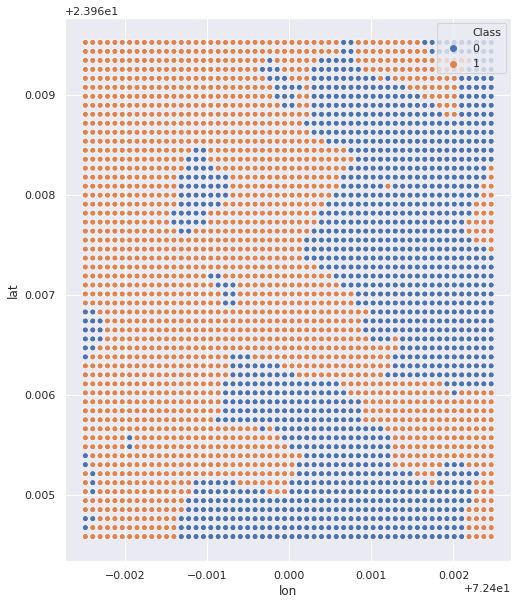

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,10)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Silhouette Coefficient is:  0.3066541494075668


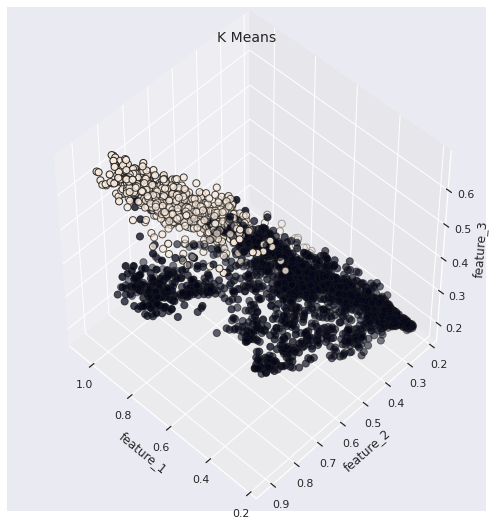

In [ ]:
ID_label = agglomerative(in_arr=ID_arr, n_classes=2)

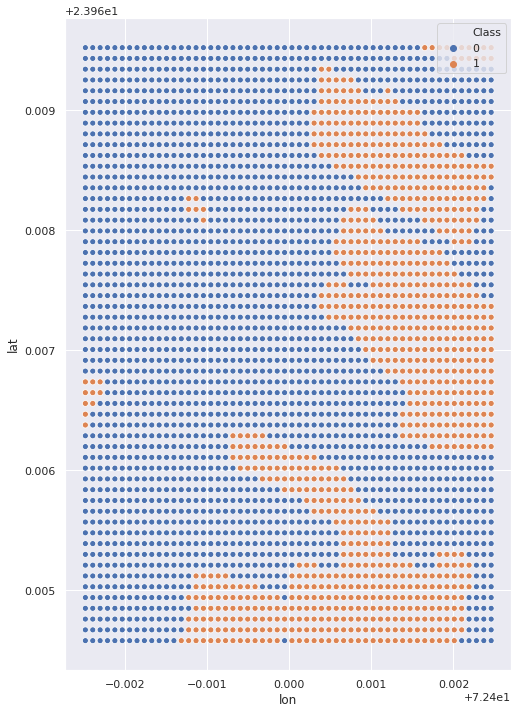

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')

Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 3ms/step - loss: 0.4083 - val_loss: 0.3471
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3311 - val_loss: 0.2567
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2397 - val_loss: 0.1959
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2089 - val_loss: 0.1971
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2075 - val_loss: 0.1962
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2063 - val_loss: 0.1961
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2050 - val_loss: 0.1939
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2036 - val_loss: 0.1937
Epoch 9/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2017 - val_loss: 0.1936
Epoch 10/50
1568/1568 [===========

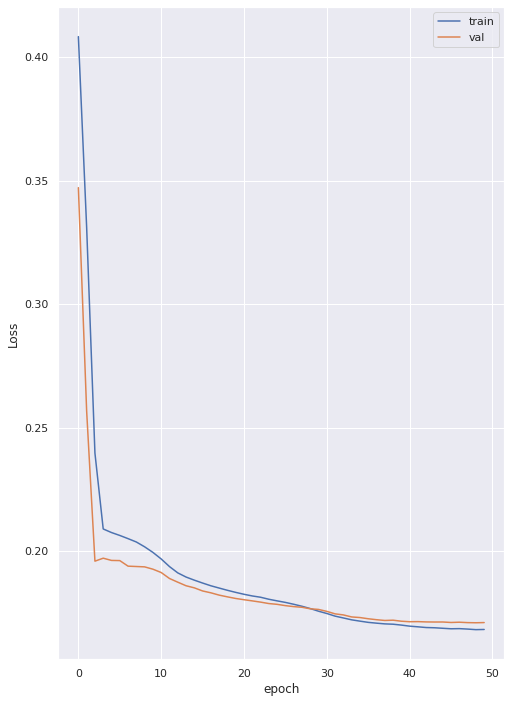

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.4159 - val_loss: 0.3643
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3666 - val_loss: 0.3149
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.3174 - val_loss: 0.2663
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2722 - val_loss: 0.2286
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2408 - val_loss: 0.2060
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2225 - val_loss: 0.1945
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2120 - val_loss: 0.1882
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/step - 

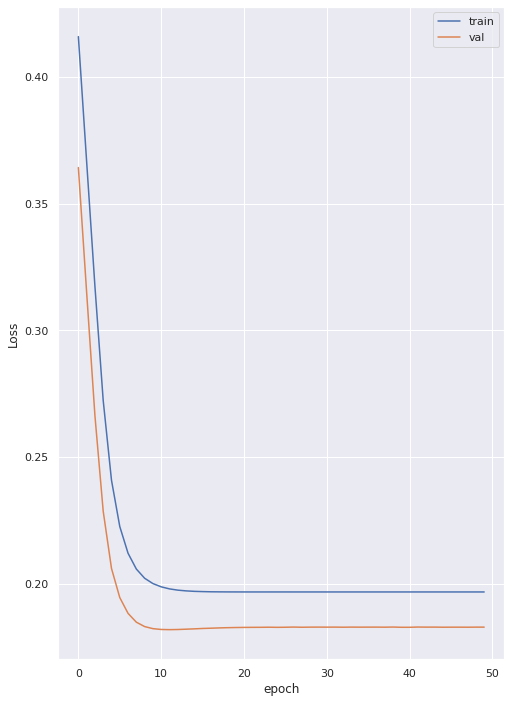

Column 0 has 100.00% of zeros
Column 1 has 100.00% of zeros
Column 2 has 100.00% of zeros
At least 1 column is all zeros. Refit -------------------------------------------
Train on 1568 samples, validate on 1568 samples
Epoch 1/50
1568/1568 [==============================] - 4s 2ms/step - loss: 0.2856 - val_loss: 0.2067
Epoch 2/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2136 - val_loss: 0.2051
Epoch 3/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2110 - val_loss: 0.2029
Epoch 4/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2086 - val_loss: 0.1998
Epoch 5/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.2041 - val_loss: 0.1960
Epoch 6/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1999 - val_loss: 0.1926
Epoch 7/50
1568/1568 [==============================] - 3s 2ms/step - loss: 0.1969 - val_loss: 0.1897
Epoch 8/50
1568/1568 [==============================] - 3s 2ms/ste

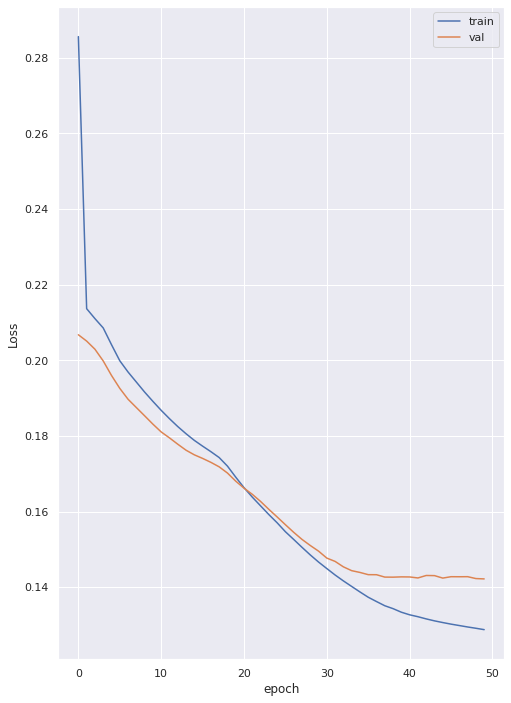

Column 0 has 0.00% of zeros
Column 1 has 0.00% of zeros
Column 2 has 0.00% of zeros


In [ ]:
ID_feature = LSTM_autoencoder_plus(in_arr=ID_arr, n_features=3, n_epochs=50)

Silhouette Coefficient is:  0.62599385


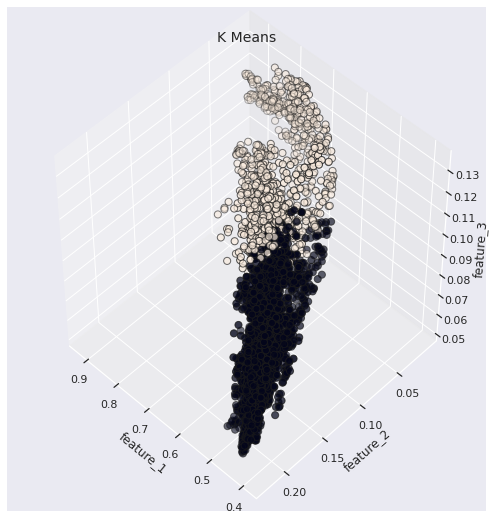

In [ ]:
ID_label = kmeans(in_arr=ID_feature, n_classes=2)

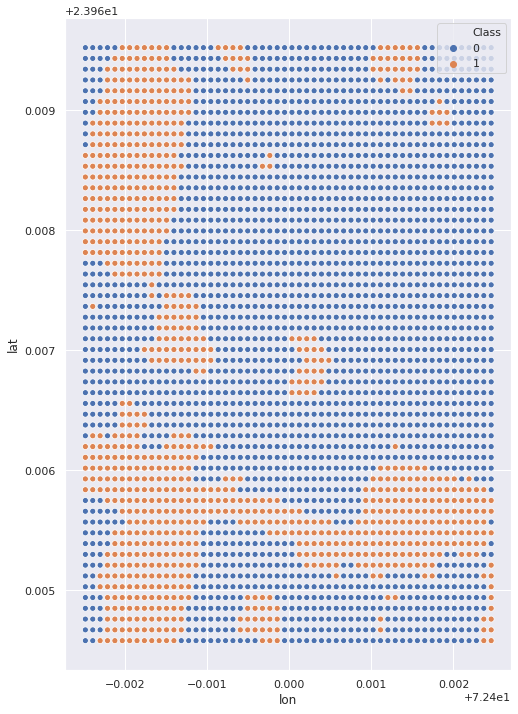

In [ ]:
ID_prediction = pd.Series(ID_label, name="Class")
ID_df2 = ID_df.merge(ID_prediction.to_frame(), left_index=True, right_index=True)
sns.set(rc={'figure.figsize':(8,12)})
sns.scatterplot(data=ID_df2, x='lon', y='lat', hue='Class')